# ADASS 2024 Demonstration
Manon Marchand$^1$

1. Strasbourg Astronomical Data Centre (CDS)

This notebook follows the presentation given during ADASS 2024 conference in Malta, on November 14.
You can run it by installing the packages described in the file `requirements.txt`:

`pip install -r requirements.txt`

---

Let's import `ipyaladin` (the star of the show) and `sidecar` (to pop ipyaladin on the side of the notebook rather than in between cells):


In [10]:
from ipyaladin import Aladin
from sidecar import Sidecar

## 1. Instantiation on the side of the notebook

This will only work in JupyterLab. For other notebooks platforms, reach their documentation to see how/wether this can be done.

In [11]:
aladin = Aladin()
with Sidecar(title="aladin_output"):
    display(aladin)

Now that the widget is opened on the side, we can resize the window as needed.
The view can be zoomed in and out, or panned. This is a fully functionnal [Aladin Lite](https://github.com/cds-astro/aladin-lite) instance!

## 2. Communication between python and ipyaladin

The added benefit here is that it is connected to the python kernel. We can send information from `ipyaladin` to Python and *vice-versa*.

In [22]:
aladin.target = "M1"

We sent the string "M1" and the center of the view centered on the Crab Nebulae. If you cannot see it, try zooming in and out.

But `ipyaladin` can also receive some `astropy`-specific objects... and this is the whole subject of this demonstration!

## 3. Astropy SkyCoords and Angle

Let's start by sending a `astropy.coordinates.SkyCoord` object instead of a string:

In [13]:
from astropy.coordinates import SkyCoord

In [14]:
coo_perseus = SkyCoord.from_name("Perseus Cluster")

In [15]:
aladin.target = coo_perseus

And voilà, we are centered on the Perseus Cluster. Let's also change the field of view with an `astropy.coordinates.Angle` object:

In [16]:
import astropy.units as u
from astropy.coordinates import Angle

In [23]:
aladin.fov = Angle(25 * u.arcmin)

The other way around works too. We can zoom in and out until we think we have a rough estimate of the size of the galaxy cluster, and retrieve this value:

In [24]:
estimated_dimension = aladin.fov
estimated_dimension

<Angle 0.41666667 deg>

## 4. Drawing astropy-regions

Let's plot the estimation of the cluster dimension thanks to an `astropy-region`:

In [19]:
from regions import CircleSkyRegion

In [20]:
aladin.add_graphic_overlay_from_region(
    CircleSkyRegion(coo_perseus, estimated_dimension),
    color="salmon", line_dash=[5], 
    name="cluster_dimension"
)

## 5. Adding FITS files to the view

FITS files can either be dragged-and-dropped into the ipyaladin view (like with any Aladin Lite instance), or added programmatically with `add_fits`:

In [25]:
aladin.add_fits("chandra_fQoZFZw.fits", name="chandra")

## 6. Working with MOCs

### 6.1 Drawing MOCs on the view

MOCs can be interactively drawn on ipyaladin with the menu `stack` > `+ Overlays` (click on the `+`) > `MOC` >  `From selection`... and then chose your type of selection.
Here, for example, we can draw an appriximated contour for the shockwave visible in the `chandra.fits` image.

### 6.2 Sending MOCs from python to the widget

The widget can also display MOCs:

In [35]:
from mocpy import MOC
from mocpy import __version__
print("version:", __version__)

version: 0.17.1


Let's get the MOC describing the coverage on a VizieR catalog.

In [27]:
gaia_galcan_coverage = MOC.from_vizier_table(
    "I/356/galcand"
)

The result is a `mocpy.MOC` object. We can add it the the widget.

In [28]:
aladin.add_moc(gaia_galcan_coverage, 
               color="seagreen",
               name="gaia_galcan")

This method also accepts MOCs as ASCII, JSON, URL, or FITS files.

## 7. Changing the survey

### 7.1 With the graphic interface

More surveys can be found with the graphic interface of Aladin Lite. To do so, go in `stack` > `+ Surveys` (click on the `+`) > `Browse HiPS`.
Some filters can be added to restric the results by cecking the box next to `Filter`.

We can for example find that ASKAP offers data in the area by selecting the filters `Inside View` and `Regime` = `Radio`.

### 7.2 With astroquery.MOCServer

In [29]:
from astroquery.mocserver import MOCServer

Let's look for datasets with the word `Euclid` in their description:

In [30]:
MOCServer.find_datasets(meta_data="*Euclid*")

ID,obs_title,obs_description,obs_regime,dataproduct_type
str28,str52,str568,str8,str5
CDS/P/Euclid/ERO/FirstImages,Euclid Early Release Observations (ERO) First Images,"This HiPS is made of the five first images in the frame of Euclid ERO (Early Release Observations). Color composition made from VIS (0.53-0.92um wide-band), and near-infrared Y and H bands. Astrometry was added by CDS using astrometry.net software.",Optical,image
CDS/P/Euclid/ERO/NISP.H,Euclid ERO NISP.H,"The ERO programme is an initiative of ESA and the Euclid Science Team: it includes one day of observations, taken before the start of the nominal survey, to showcase the capabilities of the ESA Euclid mission.Seventeen targets, from galaxy clusters, nearby galaxies, globular clusters, to star-forming regions, have been observed and analyzed. Details on selected ERO projects are available at https://www.cosmos.esa.int/web/euclid/ero-public-release",Infrared,image
CDS/P/Euclid/ERO/NISP.J,Euclid ERO NISP.J,"The ERO programme is an initiative of ESA and the Euclid Science Team: it includes one day of observations, taken before the start of the nominal survey, to showcase the capabilities of the ESA Euclid mission.Seventeen targets, from galaxy clusters, nearby galaxies, globular clusters, to star-forming regions, have been observed and analyzed. Details on selected ERO projects are available at https://www.cosmos.esa.int/web/euclid/ero-public-release",Infrared,image
CDS/P/Euclid/ERO/NISP.Y,Euclid ERO NISP.Y,"The ERO programme is an initiative of ESA and the Euclid Science Team: it includes one day of observations, taken before the start of the nominal survey, to showcase the capabilities of the ESA Euclid mission.Seventeen targets, from galaxy clusters, nearby galaxies, globular clusters, to star-forming regions, have been observed and analyzed. Details on selected ERO projects are available at https://www.cosmos.esa.int/web/euclid/ero-public-release",Infrared,image
CDS/P/Euclid/ERO/VIS,Euclid ERO VIS,"The ERO programme is an initiative of ESA and the Euclid Science Team: it includes one day of observations, taken before the start of the nominal survey, to showcase the capabilities of the ESA Euclid mission.Seventeen targets, from galaxy clusters, nearby galaxies, globular clusters, to star-forming regions, have been observed and analyzed. Details on selected ERO projects are available at https://www.cosmos.esa.int/web/euclid/ero-public-release",Optical,image
CDS/P/Euclid/ERO/color,"Euclid ERO color (filters H, Y, VIS)","The ERO programme is an initiative of ESA and the Euclid Science Team: it includes one day of observations, taken before the start of the nominal survey, to showcase the capabilities of the ESA Euclid mission.Seventeen targets, from galaxy clusters, nearby galaxies, globular clusters, to star-forming regions, have been observed and analyzed. Details on selected ERO projects are available at https://www.cosmos.esa.int/web/euclid/ero-public-release . This HiPS has been built by CDS from HiPS CDS/P/Euclid/ERO/NISP.H, CDS/P/Euclid/ERO/NISP.Y and CDS/P/Euclid/ERO/VIS",Infrared,image


In [31]:
aladin.survey = "CDS/P/Euclid/ERO/VIS"

The view changed from the default survey to the Euclid one.

## 8. Getting a FITS of the current view

This uses the [Hips2FITS](https://alasky.cds.unistra.fr/hips-image-services/hips2fits) image cutout service.

In [36]:
euclid_cutout = aladin.get_view_as_fits()[0]

WidgetReducedError: Jupyter reduces the size of the widget when it is out of the view. This leads to wrong WCS. Either scroll up to the widget, and query the WCS from there, or use the right click menu 'Create New View for Cell Output' to keep the widget in the screen.

In [37]:
import matplotlib.pyplot as plt
import numpy as np

TypeError: Invalid shape (3, 400, 346) for image data

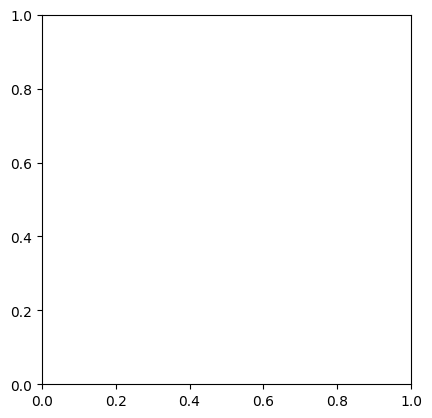

In [38]:
plt.imshow(np.flipud(euclid_cutout.data.astype("short")),
           cmap="Greys_r", norm="asinh", vmin=10, vmax=50)

The WCS of the current view can also be read at all times:

In [ ]:
aladin.wcs

## 9. Working with catalogs

### 9.1 Adding catalogs to the widget

In [39]:
from astroquery.vizier import Vizier

In [40]:
extra_galactic = Vizier(catalog="I/356/galcand", 
                        row_limit=-1).query_region(
    coo_perseus,
    radius=estimated_dimension
)[0]
extra_galactic

/Users/brian.merino/opt/anaconda3/envs/aladin_adass/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


Source,SolID,Class,PGal,PQSO,z,RA_ICRS,DE_ICRS,_RA.icrs,_DE.icrs
,,,,,,deg,deg,deg,deg
int64,int64,str15,float64,float64,float64,float64,float64,float64,float64
236394626313346176,1636148068921376768,GALAXY,0.002640629,0,--,50.12782551084,41.16993123243,50.12782551084,41.16993123243
236401807498779648,1636148068921376768,GALAXY,1,0,--,50.28692933846,41.25302537633,50.28692933846,41.25302537633
236423007456210304,1636148068921376768,,1,0,--,50.40754703507,41.35780385800,50.40754703507,41.35780385800
236423385414348544,1636148068921376768,,1,1.81969e-12,0.0708228,50.41654170777,41.36056332082,50.41654170777,41.36056332082
236426134193543424,1636148068921376768,GALAXY,0.001810538,1.700015e-05,--,50.32452257791,41.36637127976,50.32452257791,41.36637127976
236426443431188608,1636148068921376768,,1,0,--,50.40191364558,41.39281214848,50.40191364558,41.39281214848
236427783459825152,1636148068921376768,,1,0,0.0708228,50.33681897585,41.46004173339,50.33681897585,41.46004173339
236429054770110848,1636148068921376768,,1,1.694126e-12,0.0798532,50.48951994825,41.55218778391,50.48951994825,41.55218778391


In [41]:
aladin.add_table(
    extra_galactic[extra_galactic["Class"] 
    == "GALAXY"], 
    shape="circle",
    source_size=15, 
    color="lightblue",             
    name="galaxies")

In [42]:
aladin.add_table(
    extra_galactic[extra_galactic["Class"] 
    != "GALAXY"], 
    shape="circle",
    source_size=15, 
    color="pink",             
    name="galaxies")

### 9.2 Making a sub-selection

To get a sub-selection of these two tables, right click on the widget, and chose `Select Sources` in the context menu that appears.
The last selection is stored as a list of `astropy.Table` in the attribute `aladin.selected_objects`.

If you've selected sources from the two tables, you can recover them with:

In [43]:
aladin.selected_objects[0]

IndexError: list index out of range

In [44]:
aladin.selected_objects[1]

IndexError: list index out of range

## Conclusion

This was a brief presentation of the features of `ipyaladin` that makes it compatible with the astropy ecosystem. Namely, we've seen that the following objects/libraries are currently supported:

- astropy.coordinates.SkyCoord
- astropy.coordinates.Angle
- astropy-regions (astropy affiliated)
- astropy.io.fits
- mocpy.MOC (astropy affiliated)
- astropy.Table

If you need other objects, don't hesitate to open an issue in `ipyaladin`'s repository https://github.com/cds-astro/ipyaladin

### Useful links

- [ipyaladin's documentation](https://cds-astro.github.io/ipyaladin/)
- [CDS's reporitory of tutorials](https://github.com/cds-astro/tutorials) (they showcase ipyaladin too)